# Introduction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from ydata_profiling import ProfileReport

from sklearn import metrics
from scipy import stats
from scipy.stats import norm

%matplotlib inline

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

RANDOM_STATE = 42
TEST_SIZE = 0.25
N_THREADS = 4
N_FOLDS = 5
CV = 5
TIMEOUT = 300

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Импортируем df
data = pd.read_csv(
    r"ds_salaries.csv"
)
df = data.copy()

# EDA

In [3]:
# fast EDA

# profile = ProfileReport(df, title="Profiling Report")
# profile

## Data quality

### Missing values

In [4]:
#check missing ratio
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

Empty DataFrame
Columns: [Missing Ratio]
Index: []

### Duplicates

In [5]:
# Handle duplicates
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (1171, 11)


### Check Unique Value in each columns

In [6]:
# Loop through each column and count the number of distinct values
for col in df.columns:
    num_distinct_values = len(df[col].unique())
    print(f"{col}: {num_distinct_values} distinct values")

work_year: 4 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 93 distinct values
salary: 815 distinct values
salary_currency: 20 distinct values
salary_in_usd: 1035 distinct values
employee_residence: 78 distinct values
remote_ratio: 3 distinct values
company_location: 72 distinct values
company_size: 3 distinct values


In [7]:
# Check unique values in each column
for col in df.columns:
    print(col)
    print(df[col].unique(), '\n')

work_year
[2023 2022 2020 2021] 

experience_level
['SE' 'MI' 'EN' 'EX'] 

employment_type
['FT' 'CT' 'FL' 'PT'] 

job_title
['Principal Data Scientist' 'ML Engineer' 'Data Scientist'
 'Applied Scientist' 'Data Analyst' 'Data Modeler' 'Research Engineer'
 'Analytics Engineer' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Strategist' 'Data Engineer'
 'Computer Vision Engineer' 'Data Quality Analyst'
 'Compliance Data Analyst' 'Data Architect'
 'Applied Machine Learning Engineer' 'AI Developer' 'Research Scientist'
 'Data Analytics Manager' 'Business Data Analyst' 'Applied Data Scientist'
 'Staff Data Analyst' 'ETL Engineer' 'Data DevOps Engineer' 'Head of Data'
 'Data Science Manager' 'Data Manager' 'Machine Learning Researcher'
 'Big Data Engineer' 'Data Specialist' 'Lead Data Analyst'
 'BI Data Engineer' 'Director of Data Science'
 'Machine Learning Scientist' 'MLOps Engineer' 'AI Scientist'
 'Autonomous Vehicle Technician' 'Applied Machine Learning Scientist'
 '

### Explore the data

In [8]:
df[:3]

work_year experience_level employment_type                 job_title  \
0       2023               SE              FT  Principal Data Scientist   
1       2023               MI              CT               ML Engineer   
2       2023               MI              CT               ML Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   80000             EUR          85847                 ES           100   
1   30000             USD          30000                 US           100   
2   25500             USD          25500                 US           100   

  company_location company_size  
0               ES            L  
1               US            S  
2               US            S

### Rename for better understanding

In [9]:
df['experience_level'] = df['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry_level',
    'EX': 'Executive_level',
    'MI': 'Mid_level',
})

df['employment_type'] = df['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full_time',
    'PT' : 'Part_time'
})
df['company_size'] = df['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
df['remote_ratio'] = df['remote_ratio'].astype(str)
df['remote_ratio'] = df['remote_ratio'].replace({
    '0': 'On_Site',
    '50': 'Half_Remote',
    '100' : 'Full_Remote',
})

### Group the job title

In [10]:
def assign_broader_category(job_title):
    data_engineering = [
        "Data Engineer", "Data Analyst", "Analytics Engineer",
        "BI Data Analyst", "Business Data Analyst", "BI Developer",
        "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer",
        "Power BI Developer"
    ]
    data_scientist = [
        "Data Scientist", "Applied Scientist", "Research Scientist",
        "3D Computer Vision Researcher", "Deep Learning Researcher",
        "AI/Computer Vision Engineer"
    ]
    machine_learning = [
        "Machine Learning Engineer", "ML Engineer",
        "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"
    ]
    data_architecture = [
        "Data Architect", "Big Data Architect", "Cloud Data Architect",
        "Principal Data Architect"
    ]
    management = [
        "Data Science Manager", "Director of Data Science",
        "Head of Data Science", "Data Scientist Lead",
        "Head of Machine Learning", "Manager Data Management",
        "Data Analytics Manager"
    ]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
        return "Management"
    else:
        return "Other"


# Apply the function to the 'job_title' column and create a new column 'job_category'
df['job_category'] = df['job_title'].apply(assign_broader_category)

## Dealing with Inflation rate

In order to accurately compare salaries across different years, it is essential to account for inflation. Inflation is the rate at which the general price levels of goods and services increase over time. By adjusting salaries to a common currency and year, we can make meaningful comparisons between them.

**Method**
- Define inflation rates for the United States (US) and global markets. These rates will be used to adjust the salaries based on the year and currency.
- Create a function adjust_salary() that takes a row from the dataset as input and calculates the adjusted salary based on the work year, original salary, and currency. If the work year is 2023, the salary does not need to be adjusted, and the original salary is returned.
- Determine the number of years between the work year and 2023 . Use the appropriate inflation rate based on the currency, either the US or global inflation rate.
- Calculate the adjusted salary by applying the inflation rate to the original salary for each year from the work year to 2023.
- Apply the adjust_salary() function to the dataset using the apply() method, and create a new column 'adjusted_salary' with the adjusted salary values.

In [11]:
# Inflation rates
us_inflation_rates = {2019: 0.0181, 2020: 0.0123, 2021: 0.0470, 2022: 0.065}
global_inflation_rates = {2019: 0.0219, 2020: 0.0192, 2021: 0.0350, 2022: 0.088}


# Function to adjust salary
def adjust_salary(row):
    year = row['work_year']
    original_salary = row['salary_in_usd']
    currency = row['salary_currency']

    if year == 2023:
        return original_salary

    adjusted_salary = original_salary
    for y in range(year, 2023):
        if currency == 'USD':
            inflation_rate = us_inflation_rates[y]
        else:
            inflation_rate = global_inflation_rates[y]

        adjusted_salary *= (1 + inflation_rate)

    return adjusted_salary


# Apply the function to the dataset
df['adjusted_salary'] = df.apply(adjust_salary, axis=1)

## Univariate

### Target (adjusted_salary)

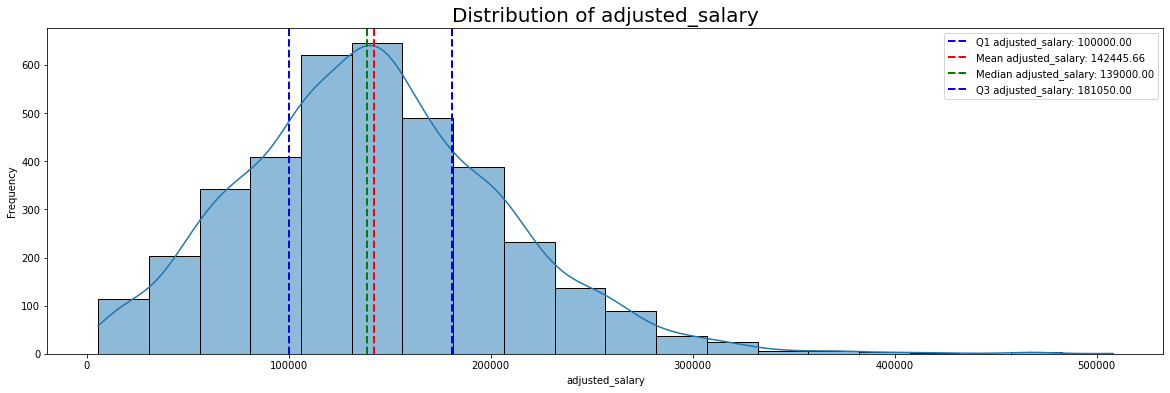

In [12]:
# Create a list of the columns to analyze
target = ['adjusted_salary']

# Loop over the columns and plot the distribution of each variable
for col in target:
    # Calculate summary statistics for numeric_cols
    mean_ = df[col].mean()
    median_ = df[col].median()
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)

    # Create an age distribution plot (histogram)
    plt.figure(figsize=(20, 6))
    sns.histplot(df[col].dropna(), bins=20, kde=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + col, {'fontsize': 20})
    plt.axvline(Q1,
                color='blue',
                linestyle='dashed',
                linewidth=2,
                label=f'Q1 {col}: {Q1:.2f}')
    plt.axvline(mean_,
                color='red',
                linestyle='dashed',
                linewidth=2,
                label=f'Mean {col}: {mean_:.2f}')
    plt.axvline(median_,
                color='green',
                linestyle='dashed',
                linewidth=2,
                label=f'Median {col}: {median_:.2f}')
    plt.axvline(Q3,
                color='blue',
                linestyle='dashed',
                linewidth=2,
                label=f'Q3 {col}: {Q3:.2f}')
    plt.legend()
    plt.show()

**Выводы:**

- The salary distribution for data science professionals is right-skewed, with a majority of professionals earning lower to mid-range salaries.
- A noticeable peak in the distribution suggests a concentration of professionals within a specific salary range.
- The KDE (Kernel Density Estimate) curve provides a smooth estimate of the distribution, showing a prominent peak.

adjusted_salary: mu = 142445.66, sigma = 64692.98
adjusted_salary: Skewness: 0.58
adjusted_salary: Kurtosis: 1.14


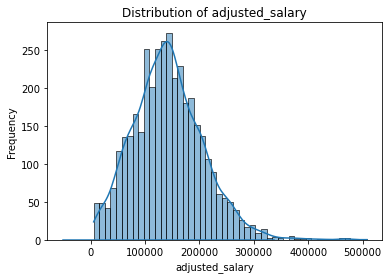

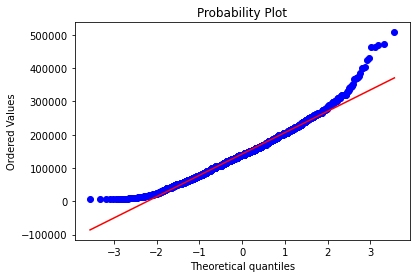

In [13]:
# Create a list of the columns to analyze
columns = ['adjusted_salary']

# Loop over the columns and plot the distribution of each variable
for col in columns:
    # Plot the distribution of the data
    sns.histplot(df[col], kde=True)

    # Fit a normal distribution to the data
    (mu, sigma) = stats.norm.fit(df[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calculate the skewness and kurtosis of the data
    print('{}: Skewness: {:.2f}'.format(col, df[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, df[col].kurt()))

    # Add the fitted normal distribution to the plot
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Add labels and title to the plot
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))

    # Plot the QQ-plot
    fig = plt.figure()
    stats.probplot(df[col], plot=plt)

    plt.show()

### Job Distribution

In [14]:
# Word Cloud
from wordcloud import WordCloud
import nltk


def Freq_df(word_list):
    Freq_dist_nltk = nltk.FreqDist(word_list)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'], ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq


def Word_Cloud(data, title):
    plt.figure(figsize=(20, 15))
    wc = WordCloud(width=1200,
                   height=600,
                   max_words=50,
                   background_color='white',
                   max_font_size=100,
                   random_state=42)
    wc.generate_from_frequencies(data)

    plt.imshow(wc)
    plt.title(title)
    plt.axis('off')
    plt.show()

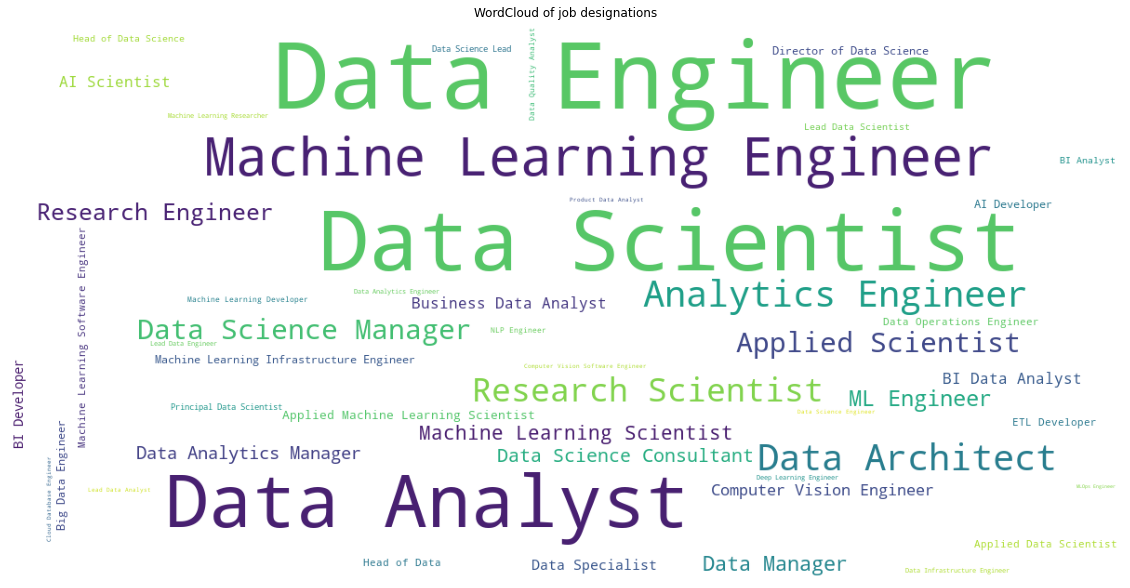

In [15]:
# Word cloud (4fun)
freq_df = Freq_df(df['job_title'].values.tolist())
data_w = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data_w = freq_df.set_index('Term').to_dict()['Frequency']

Word_Cloud(data_w, 'WordCloud of job designations')

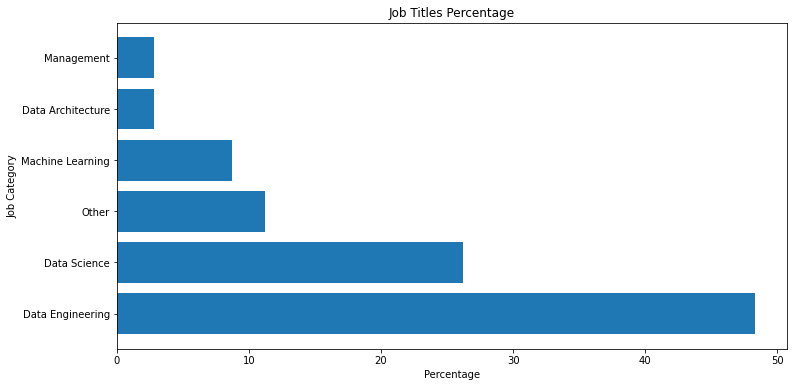

In [16]:
# Aggregated distibution of job titles
value_counts = df['job_category'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(12, 6))
top_n = min(17, len(value_counts))
ax.barh(value_counts.index[:top_n], value_counts.values[:top_n])
ax.set_xlabel('Percentage')
ax.set_ylabel('Job Category')
ax.set_title('Job Titles Percentage')
plt.show()

In [17]:
# job_title

top10_job_titles = df['job_category'].value_counts()
fig = px.bar(y=top10_job_titles.values,
             x=top10_job_titles.index,
             text=top10_job_titles.values,
             title='Top Job Designations')
fig.update_layout(xaxis_title="Job Designations", yaxis_title="Count")
fig.show()

### Distribution across different employment types

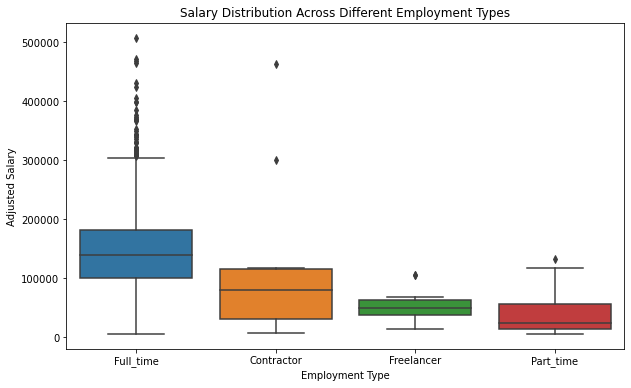

In [18]:
# Salary distribution across different employment types
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='employment_type', y='adjusted_salary')
plt.title('Salary Distribution Across Different Employment Types')
plt.xlabel('Employment Type')
plt.ylabel('Adjusted Salary')
plt.show()

### Distribution of experience level

In [19]:
exp_lvl = df['experience_level'].value_counts()
fig = px.treemap(exp_lvl,
                 path=[exp_lvl.index],
                 values=exp_lvl.values,
                 title='Experience Level')
fig.show()

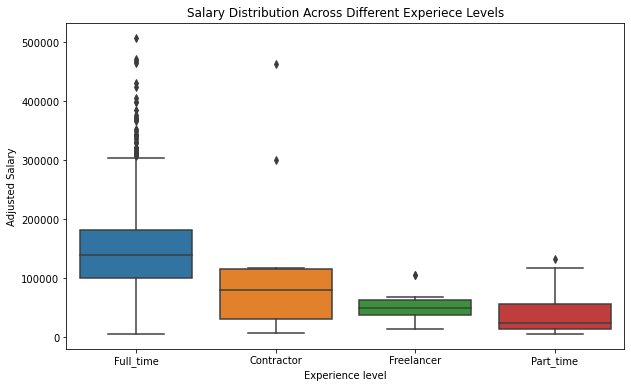

In [20]:
# Salary between different lvl of exp
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='employment_type', y='adjusted_salary')
plt.title('Salary Distribution Across Different Experiece Levels')
plt.xlabel('Experience level')
plt.ylabel('Adjusted Salary')
plt.show()

### Company size

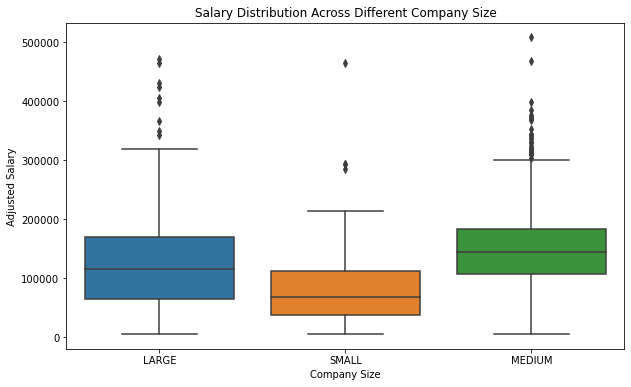

In [21]:
# Salary between different company size
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='company_size', y='adjusted_salary')
plt.title('Salary Distribution Across Different Company Size')
plt.xlabel('Company Size')
plt.ylabel('Adjusted Salary')
plt.show()

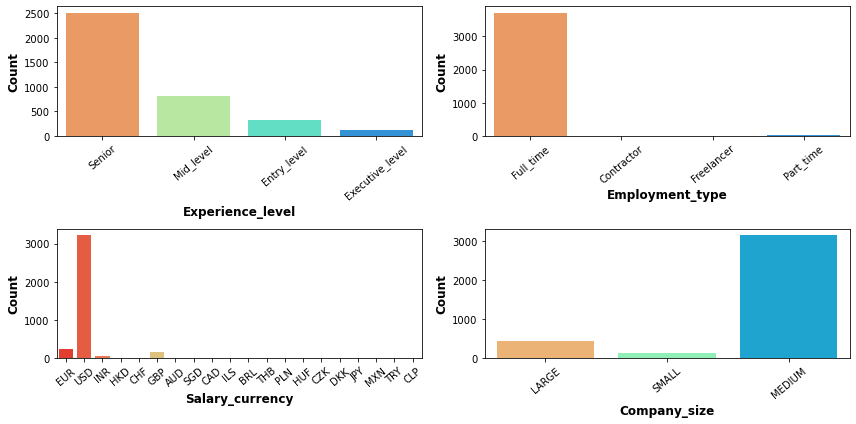

In [22]:
fig, axis = plt.subplots(2, 2, figsize=(12, 6))

columns = [
    'experience_level', 'employment_type', 'salary_currency', 'company_size'
]
axis = axis.flatten()
for i, col in enumerate(columns):
    p = sns.countplot(data=df, x=df[col], ax=axis[i], palette="rainbow_r")
    axis[i].set_xticklabels(axis[i].get_xticklabels(), rotation=40)
    axis[i].set_xlabel(col.capitalize(), fontsize=12, fontweight='bold')
    axis[i].set_ylabel('Count', fontsize=12, fontweight='bold')

# Remove any remaining empty subplots
for j in range(len(columns), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

## Bivariate

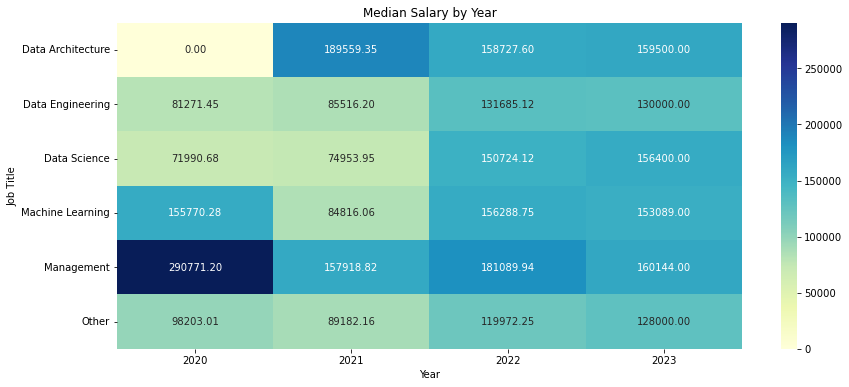

In [23]:
#  Median salary by job title
pivot_table = df.pivot_table(values='adjusted_salary',
                             index='job_category',
                             columns='work_year',
                             aggfunc='median',
                             fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Median Salary by Year')
plt.xlabel('Year')
plt.ylabel('Job Title')
plt.show()

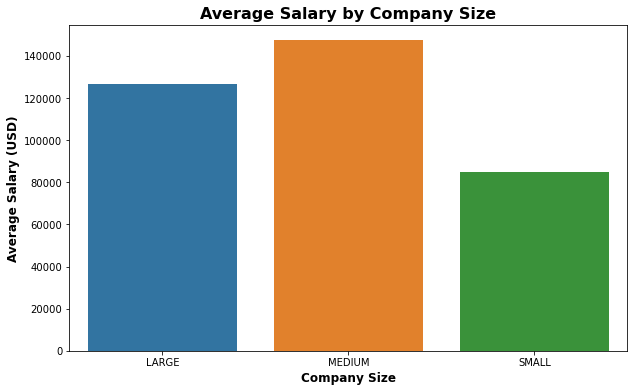

In [25]:
# average salary by company size
company_size_salary = df.groupby('company_size')['adjusted_salary'].mean()

plt.figure(figsize=(10, 6))
p = sns.barplot(x=company_size_salary.index, y=company_size_salary.values)

plt.title('Average Salary by Company Size', fontsize=16, fontweight='bold')
plt.xlabel('Company Size', fontsize=12, fontweight='bold')
plt.ylabel('Average Salary (USD)', fontsize=12, fontweight='bold')

plt.show()

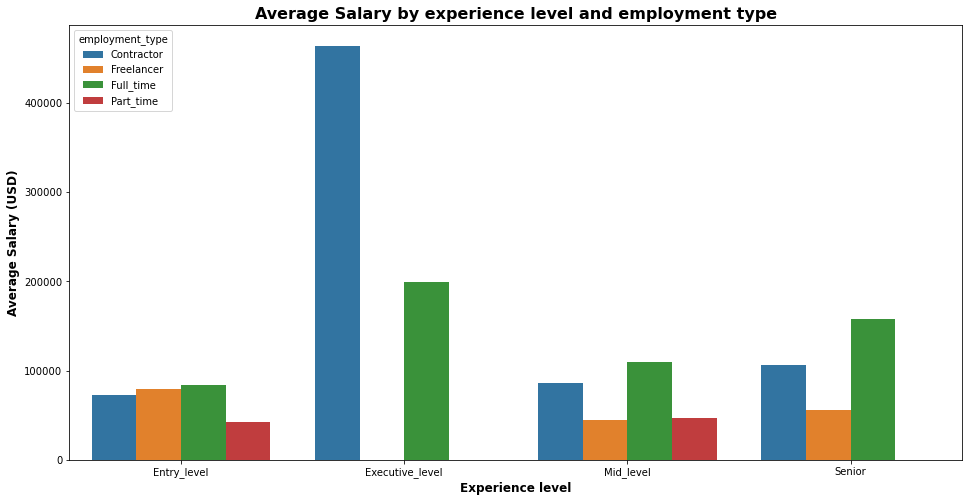

In [26]:
emp_exp_salary = df.groupby(['employment_type', 'experience_level'],
                            as_index=False)['adjusted_salary'].mean()

plt.figure(figsize=(16, 8))
ax = sns.barplot(x='experience_level',
                 y='adjusted_salary',
                 hue='employment_type',
                 data=emp_exp_salary)

plt.title('Average Salary by experience level and employment type',
          fontsize=16,
          fontweight='bold')
plt.xlabel('Experience level', fontsize=12, fontweight='bold')
plt.ylabel('Average Salary (USD)', fontsize=12, fontweight='bold')

# for container in ax.containers:
#     ax.bar_label(container, label_type="edge", color="black",
# #                  padding=6,
#                  fontweight='bold',
#                  fontsize=12,
#                  bbox={'boxstyle': 'round,pad=0.3', 'facecolor': 'white', 'edgecolor': 'black'})

plt.show()

In [27]:
df['company_size'].unique()

array(['LARGE', 'SMALL', 'MEDIUM'], dtype=object)

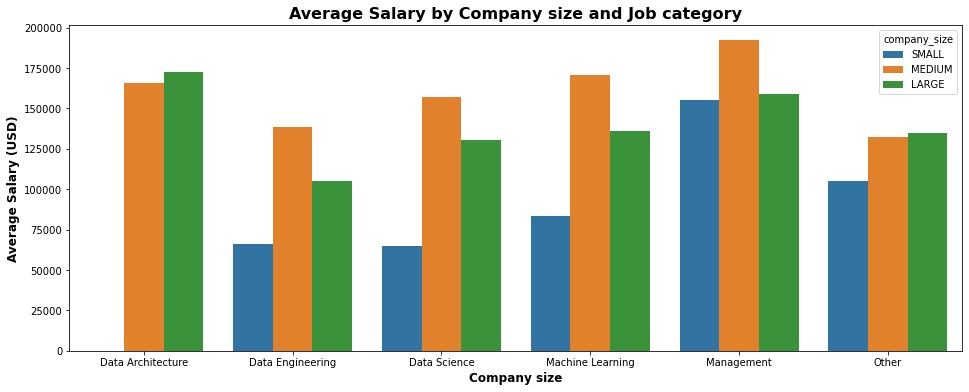

In [28]:
size_jobcat_salary = df.groupby(['company_size', 'job_category'],
                                as_index=False)['adjusted_salary'].mean()

plt.figure(figsize=(16, 6))
sns.barplot(x='job_category',
            y='adjusted_salary',
            hue='company_size',
            hue_order=['SMALL', 'MEDIUM', 'LARGE'],
            data=size_jobcat_salary)

plt.title('Average Salary by Company size and Job category',
          fontsize=16,
          fontweight='bold')
plt.xlabel('Company size', fontsize=12, fontweight='bold')
plt.ylabel('Average Salary (USD)', fontsize=12, fontweight='bold')

plt.show()

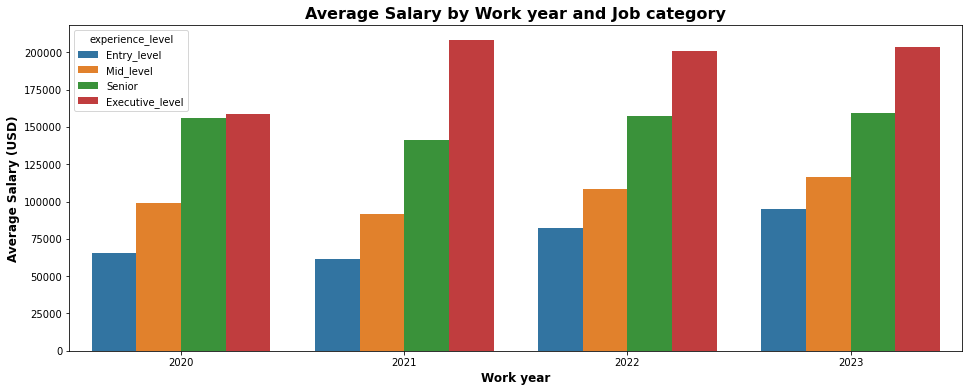

In [29]:
year_salary = df.groupby(['work_year', 'experience_level'],
                         as_index=False)['adjusted_salary'].mean()

plt.figure(figsize=(16, 6))
sns.barplot(
    x='work_year',
    y='adjusted_salary',
    hue='experience_level',
    hue_order=['Entry_level', 'Mid_level', 'Senior', 'Executive_level'],
    data=year_salary)

plt.title('Average Salary by Work year and Job category',
          fontsize=16,
          fontweight='bold')
plt.xlabel('Work year', fontsize=12, fontweight='bold')
plt.ylabel('Average Salary (USD)', fontsize=12, fontweight='bold')



plt.show()

## Geo analysis

In [30]:
# Import country code libraries
# !pip install pycountry -q
import pycountry


# Function to convert ISO 3166 country code to country name
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return country_code


    # Function to convert country code to full name
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except:
        return None

In [31]:
# Convert country codes to names
df['company_location'] = df['company_location'].apply(country_code_to_name)
df['employee_residence'] = df['employee_residence'].apply(country_code_to_name)

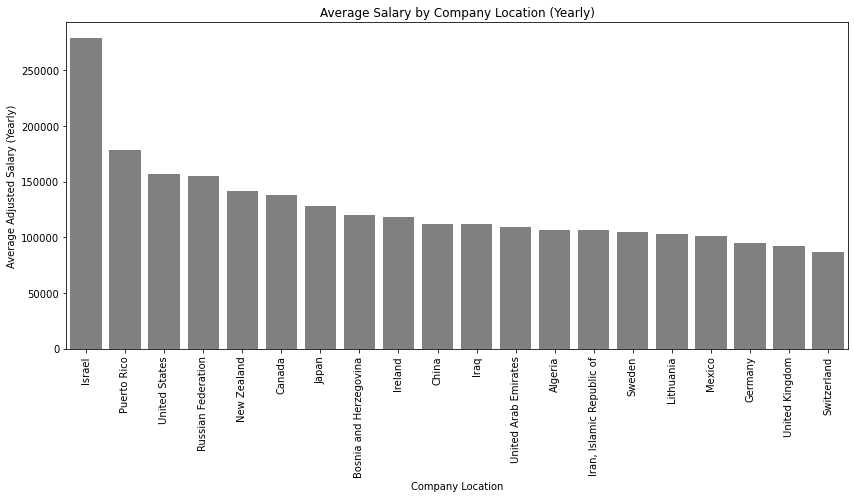

In [32]:
# Average salary by company_location
avg_salary_by_location = df.groupby('company_location',
                                    as_index=False)['adjusted_salary'].mean()

fig1 = px.choropleth(avg_salary_by_location,
                     locations='company_location',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='company_location',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Company Location',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig1.show()

# Average salary by company_location
avg_salary_by_location = df.groupby(
    'company_location')['adjusted_salary'].mean().sort_values(
        ascending=False)[:20]
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_location.index,
            y=avg_salary_by_location,
            color='grey')
plt.title('Average Salary by Company Location (Yearly)')
plt.xlabel('Company Location')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()

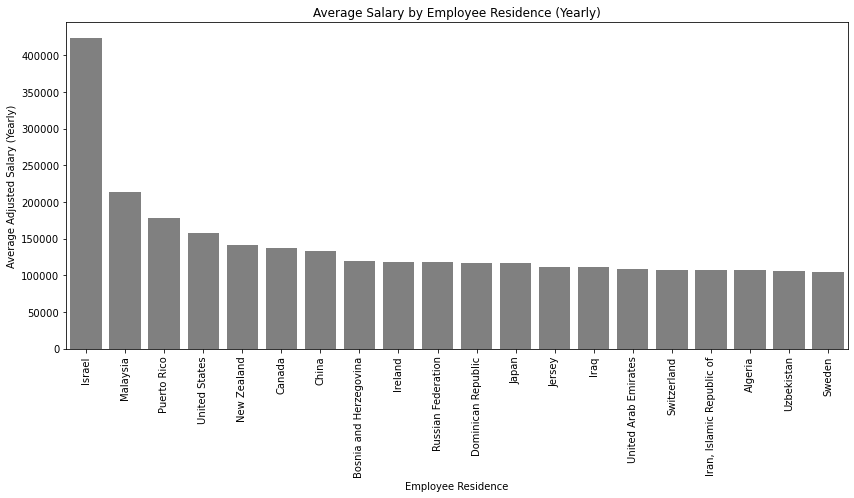

In [33]:
# Average salary by employee_residence
avg_salary_by_residence = df.groupby('employee_residence',
                                     as_index=False)['adjusted_salary'].mean()

fig2 = px.choropleth(avg_salary_by_residence,
                     locations='employee_residence',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='employee_residence',
                     color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.show()

# Average salary by employee_residence
avg_salary_by_residence = df.groupby(
    'employee_residence')['adjusted_salary'].mean().sort_values(
        ascending=False)[:20]
plt.figure(figsize=(14, 6))
sns.barplot(x=avg_salary_by_residence.index,
            y=avg_salary_by_residence.values,
            color='grey')
plt.title('Average Salary by Employee Residence (Yearly)')
plt.xlabel('Employee Residence')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()

In [34]:
# Filter for remote_ratio of 100
remote_100 = df[df['remote_ratio'] == 'Full_Remote']

# Aggregate by country code
country_counts = remote_100['company_location'].value_counts().reset_index()
country_counts.columns = ['country_code', 'count']

# Convert country codes to full names
# country_counts['country_name'] = country_counts['country_code'].apply(country_code_to_name)

# Create the choropleth map with a logarithmic color scale
fig = px.choropleth(country_counts, 
                    locations='country_code', 
                    locationmode='country names',
                    color=np.log10(country_counts['count']), 
                    hover_name='country_code',
                    hover_data=['count'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Choropleth Map of Full-Remote Company Locations',
                    projection='natural earth')

# Customize the colorbar to show the original count values
fig.update_coloraxes(colorbar=dict(title='Count (Log Scale)', tickvals=[0, 1, 2, 3], ticktext=['1', '10', '100', '1000']))

# Show the map
fig.show()

# Predictive analysis

## Data preparation

### Select Columns

In [35]:
'''
DATA
Преобразовываем страны через pycountry в изначальной таблице
create dictionary of country code to country name mappings
'''

country_map = {}
for country in pycountry.countries:
    country_map[country.alpha_2] = country.name

# replace values in 'employee_residence' column using dictionary
data['employee_residence'] = data['employee_residence'].replace(country_map)
data['company_location'] = data['company_location'].replace(country_map)

In [36]:
# Копируем изначальный df
df = data.copy()

# Добавляем столбец 'adjusted_salary'
df['adjusted_salary'] = df.apply(adjust_salary, axis=1)
# Убираем лишние колонки
df = df.drop([
    'work_year', 'salary', 'salary_currency',
    'employee_residence', 'salary_in_usd', 'salary_in_usd', 'job_title'
],
             axis=1)

In [37]:
cat_cols = [
    'experience_level', 'employment_type', 'remote_ratio', 'company_location',
    'company_size'
]
num_cols = []

### Fast EDA

In [38]:
# profile = ProfileReport(df, title="Profiling Report")
# profile

### Outliers

**Убираем слишком высокие зп в DS на entry_level**
- Есть предположение, что новички слишком много зарабатывают
- На уровне сеньоров и мидлов может выбиваться з/п
- У экзекьютов: "сколько напишешь на салфетке, столько и будет"

In [39]:
# # df.groupby('experience_level', as_index=False)['adjusted_salary'].median()
# percentiles = [0.75]
# df_exp_lvl_quant = df.groupby(
#     'experience_level',
#     as_index=False)['adjusted_salary'].quantile(percentiles)

# # manipulations with df
# df_exp_lvl_quant = df_exp_lvl_quant.reset_index().rename(
#     columns={
#         "level_1": "percentile",
#         "adjusted_salary": "adjusted_salary_q75"
#     })

# # merge dfs
# df = df.merge(df_exp_lvl_quant[['experience_level', 'adjusted_salary_q75']],
#               on='experience_level')

# # add new bool col for abnormal prices
# df['adjusted_salary_abnormal_zp'] = (df['adjusted_salary'] >
#                                      1.5 * df['adjusted_salary_q75'])

In [40]:
# cols = ['experience_level', 'company_location', 'job_category']

# for col in cols:
#     df_zp = df.groupby(
#         col, as_index=False)['adjusted_salary_abnormal_zp'].sum().sort_values(
#             by='adjusted_salary_abnormal_zp',
#             ascending=False).query('adjusted_salary_abnormal_zp > 0')
#     print(df_zp, '\n')

In [41]:
# # Можем убрать этих спецов
# print(
#     df.query('experience_level == "Entry_level" \
#     & adjusted_salary_abnormal_zp == 1 \
#     & job_category == "Data Science"').count()[0])

# df = df.drop(
#     df.query('experience_level == "Entry_level" \
#     & adjusted_salary_abnormal_zp == 1 \
#     & job_category == "Data Science"').index).reset_index(drop=True)

**Уберем таких офигевших челиков**
- У них может быть не ентри левел уровень
- Кто-то что-то напортачил при сборке данных

Но можно проще:

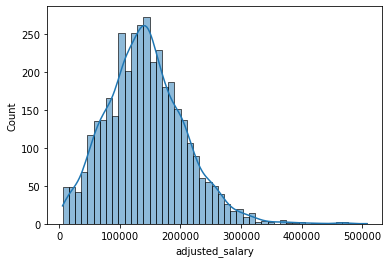

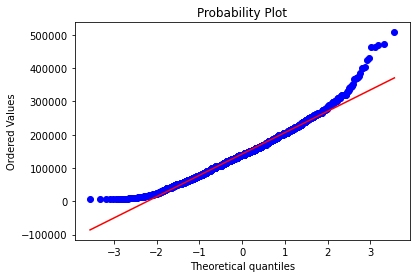

In [42]:
sns.histplot(data=df, x='adjusted_salary', kde=True)

# Plot the QQ-plot
fig = plt.figure()
stats.probplot(df['adjusted_salary'], plot=plt)

plt.show()

In [43]:
# Outlier detection using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

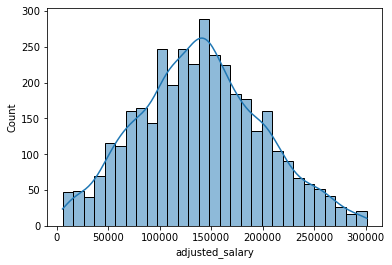

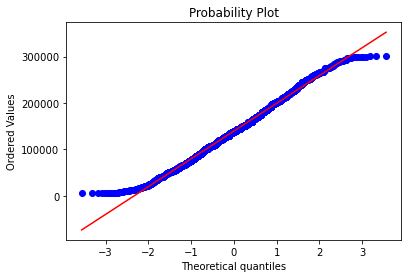

In [44]:
sns.histplot(data=df, x='adjusted_salary', kde=True)

# Plot the QQ-plot
fig = plt.figure()
stats.probplot(df['adjusted_salary'], plot=plt)

plt.show()

**Вывод:**

Числовой таргет стал ровнее, значит можем приступать к моделированию
Остальные variables перекинем в пайплайне для линейных моделей и xgb. Для остальных ничего не будем делать

### Change dtypes

In [45]:
# Сменим формат
df[cat_cols] = df[cat_cols].astype('category')

### Separate targets

In [46]:
# Calculate quantiles for salary bin edges
quantiles = [0, 1/7, 2/7, 3/7, 4/7, 5/7, 6/7, 1]
bin_edges = [df['adjusted_salary'].quantile(q) for q in quantiles]

# Convert the continuous salary variable into 7 discrete bins based on quantiles
salary_labels = [
    'low', 'low-mid', 'mid', 'mid-high', 'high', 'very-high', 'Top'
]
df['salary_range'] = pd.cut(df['adjusted_salary'],
                            bins=bin_edges,
                            labels=salary_labels,
                            include_lowest=True)

# Create final version of df
df_preprocessed = df.copy()

In [47]:
# Разделим таргеты
features = df_preprocessed.drop(['adjusted_salary', 'salary_range'], axis=1)

target_num = df_preprocessed['adjusted_salary']
target_cat = df_preprocessed['salary_range']

# Соединить два датафрейма
# df_num = pd.concat([features, target_num], axis=1)

# Predictive analysis

## Numeric target

### Import

In [48]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.compose import ColumnTransformer
import optuna

from matplotlib import pyplot as plt
from optuna.visualization.matplotlib import plot_param_importances

In [49]:
X = features
y = target_num

In [50]:
# Расчет ми скоров
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X,
                                       y,
                                       discrete_features=discrete_features,
                                       random_state=RANDOM_STATE)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


# График ми скоров
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


# Создаем функцию для убивания неинформативных фичей
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

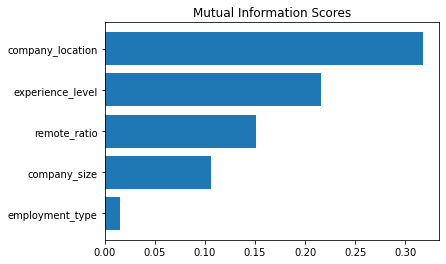

In [51]:
# Check potential feature utility
mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

**Вывод:**

Можно также убрать фичу 'employment type' при желании, тк по сравннию с остальными фичами дает прям мало в потенциальный ютилити. Фичей мало, поэтому, ничего убирать не будем.

### train / test split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RANDOM_STATE)

eval_set = [(X_val, y_val)]

### Modeling

#### General functions

In [53]:
score_results = []

In [54]:
# Основные метрики и проверка переобучения


def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Percentage Error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percentage Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """Root Mean Squared Logarithmic Error (RMSLE)"""
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    metrics_mae = mean_absolute_error(y_test, y_pred)
    metrics_mse = mean_squared_error(y_test, y_pred)
    metrics_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    metrics_rmsle = rmsle(y_test, y_pred)
    metrics_rsq = r2_score(y_test, y_pred)
    metrics_rsq_adj = r2_adjusted(y_test, y_pred, X_test)
    metrics_mpe = mpe(y_test, y_pred)
    metrics_mape = mape(y_test, y_pred)
    metrics_wape = wape(y_test, y_pred)

    score_results.append({
        'method': name,
        'metrics_mae': metrics_mae,
        'metrics_mse': metrics_mse,
        'metrics_rmse': metrics_rmse,
        'metrics_rmsle': metrics_rmsle,
        'metrics_rsq': metrics_rsq,
        'metrics_rsq_adj': metrics_rsq_adj,
        'metrics_mpe': metrics_mpe,
        'metrics_mape': metrics_mape,
        'metrics_wape': metrics_wape
    })


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """Проверка на переобучение
    metric_fun = mean_absolute_error, mean_squared_error... """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metric_train = metric_fun(y_train, y_pred_train)
    metric_test = metric_fun(y_test, y_pred_test)

    print('Check overfitting:')
    print(f'{metric_fun.__name__} train: %.3f' % metric_train)
    print(f'{metric_fun.__name__} test: %.3f' % metric_test)
    print(
        f'delta = {(abs(metric_train - metric_test) / metric_train * 100):.1f} %'
    )


def show_scores(model, X_train, y_train, X_test, y_test, metric_fun):
    resultScoreData = pd.DataFrame(score_results).set_index('method')
    resultScoreData = resultScoreData[[
        'metrics_mae', 'metrics_mse', 'metrics_rmse', 'metrics_rmsle',
        'metrics_rsq', 'metrics_rsq_adj', 'metrics_mpe', 'metrics_mape',
        'metrics_wape'
    ]]
    resultScoreData = resultScoreData.drop_duplicates()
    check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun)
    return resultScoreData

In [55]:
num_cols = []
cat_cols = [
    'experience_level', 'employment_type', 'remote_ratio', 'company_location',
    'company_size'
]

# Задаем параметры энкодеров
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# ohe = OneHotEncoder(dtype='int', drop='first')
ss = StandardScaler()

# Преобразование для колонок
transformers_list = [('encode', enc, cat_cols), ('scale', ss, num_cols)]
col_transformer = ColumnTransformer(transformers_list)

### Baseline

#### LinearRegression

In [56]:
lr = LinearRegression()
pipe = Pipeline([('columnTransformer', col_transformer), ('lr', lr)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

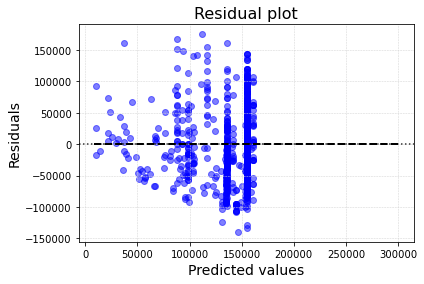

In [57]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

In [58]:
get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
show_scores(pipe,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 42044.908
mean_absolute_error test: 44569.178
delta = 6.0 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                
LinearRegression_baseline    44569.178 3078826533.693     55487.174   

                           metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                   
LinearRegression_baseline          0.503        0.168            0.163   

                           metrics_mpe  metrics_mape  metrics_wape  
method                                                              
LinearRegression_baseline      -23.733        47.557        31.401

#### RandomForestRegressor

In [59]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE)
pipe = Pipeline([('columnTransformer', col_transformer), ('rfr', rfr)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

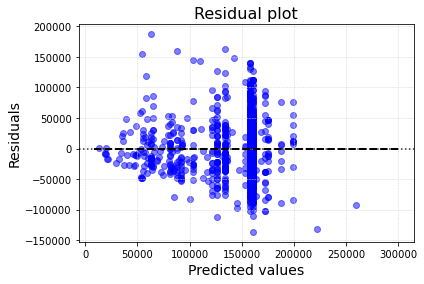

In [60]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

In [61]:
get_metrics(y_test, y_pred, X_test, 'RandomForestRegressor_baseline')
show_scores(pipe,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 34840.761
mean_absolute_error test: 39026.034
delta = 12.0 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                     
LinearRegression_baseline         44569.178 3078826533.693     55487.174   
RandomForestRegressor_baseline    39026.034 2435485985.137     49350.643   

                                metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                        
LinearRegression_baseline               0.503        0.168            0.163   
RandomForestRegressor_baseline          0.401        0.342            0.338   

                                metrics_mpe  metrics_mape  metrics_wape  
method                                                                   
LinearRegression_baseline           -23.733        47.557        31.401  
RandomForestRegressor_baseline      -15.225        36.074        27.495

#### LGBMRegressor

In [62]:
lgb = LGBMRegressor(random_state=RANDOM_STATE, objective='mae')
lgb.fit(X_train_, y_train_, eval_metric="mae", eval_set=eval_set)

y_pred = lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 2333, number of used features: 5
[LightGBM] [Info] Start training from score 138450.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

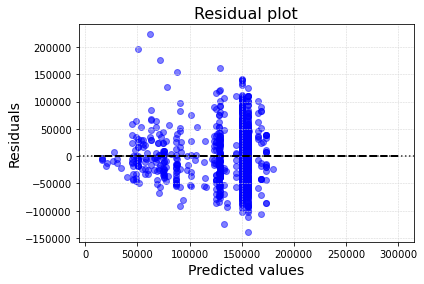

In [63]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha': 0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

In [64]:
get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline')
show_scores(lgb,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 36125.443
mean_absolute_error test: 39083.738
delta = 8.2 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                     
LinearRegression_baseline         44569.178 3078826533.693     55487.174   
RandomForestRegressor_baseline    39026.034 2435485985.137     49350.643   
LGBMRegressor_baseline            39083.738 2548423106.408     50481.909   

                                metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                        
LinearRegression_baseline               0.503        0.168            0.163   
RandomForestRegressor_baseline          0.401        0.342            0.338   
LGBMRegressor_baseline                  0.407        0.311            0.307   

                                metrics_mpe  metrics_mape  metrics_wape  
method                                                                   
LinearRegression_baseline           -23.733        47.557        31.401  
RandomForestRegressor_baseline      -15.225        36.074        27.495  
LGBMRegressor_baseline              -10.647        35.159        27.536

#### CatBoostRegressor

In [65]:
cat_features = X_val.select_dtypes('category').columns.tolist()

cb = CatBoostRegressor(random_seed=RANDOM_STATE,
                       loss_function="MAE",
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb.fit(X_train_,
       y_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)

y_pred_cb = cb.predict(X_test)

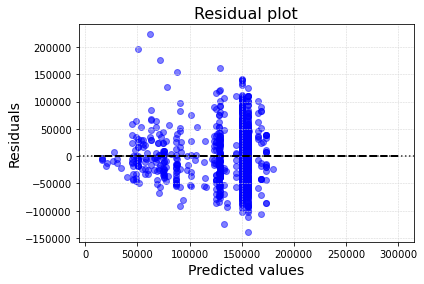

In [66]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

In [67]:
get_metrics(y_test, y_pred_cb, X_test, 'CatBoostRegressor_baseline')
show_scores(cb,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 36264.397
mean_absolute_error test: 38770.008
delta = 6.9 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                     
LinearRegression_baseline         44569.178 3078826533.693     55487.174   
RandomForestRegressor_baseline    39026.034 2435485985.137     49350.643   
LGBMRegressor_baseline            39083.738 2548423106.408     50481.909   
CatBoostRegressor_baseline        38770.008 2493063223.049     49930.584   

                                metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                        
LinearRegression_baseline               0.503        0.168            0.163   
RandomForestRegressor_baseline          0.401        0.342            0.338   
LGBMRegressor_baseline                  0.407        0.311            0.307   
CatBoostRegressor_baseline              0.400        0.326            0.322   

                                metrics_mpe  metrics_mape  metrics_wape  
method                                                                   
LinearRegression_baseline           -23.733        47.557        31.401  
RandomForestRegressor_baseline      -15.225        36.074        27.495  
LGBMRegressor_baseline              -10.647        35.159        27.536  
CatBoostRegressor_baseline           -9.268        34.290        27.315

### Optuna

#### LGMBRegressor

In [68]:
# Целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 1000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 100),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.001, 0.3),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "objective": trial.suggest_categorical("objective", ['mae']),
        "verbosity": trial.suggest_categorical("verbosity", [-1]),
        # "early_stopping_round":
        # trial.suggest_categorical("early_stopping_round", [100]),
        "random_state": trial.suggest_categorical("random_state",
                                                  [RANDOM_STATE])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = LGBMRegressor(**lgb_params, early_stopping_rounds=50)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae")

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [69]:
study = optuna.create_study(
    direction="minimize",
    study_name="LGB_1",
    storage='sqlite:///ex.db',
    load_if_exists=True,
)


def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RANDOM_STATE)


optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2023-12-11 10:22:36,991] Using an existing study with name 'LGB_1' instead of creating a new one.


  0%|          | 0/15 [00:00<?, ?it/s]

In [70]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.2983070173490781,
 'num_leaves': 74,
 'max_depth': 11,
 'min_child_samples': 149,
 'reg_alpha': 0.20333008839371483,
 'reg_lambda': 0.18039463616887985,
 'min_child_weight': 0.025324996172071897,
 'colsample_bytree': 0.732434062718866,
 'objective': 'mae',
 'verbosity': -1,
 'random_state': 42}

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

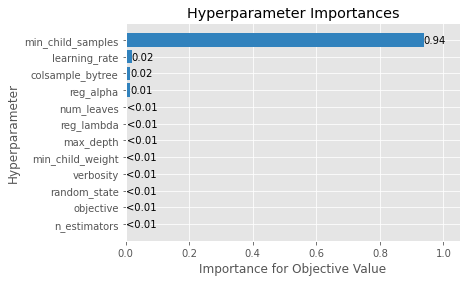

In [71]:
plot_param_importances(study)

In [72]:
lgb_optuna = LGBMRegressor(**study.best_params)
lgb_optuna.fit(X_train_, y_train_, eval_metric="mae", eval_set=eval_set)
y_pred = lgb_optuna.predict(X_test)

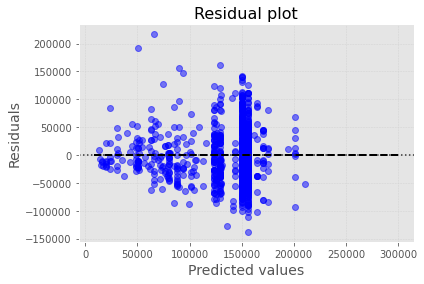

In [73]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

In [74]:
get_metrics(y_test, y_pred, X_test, 'LGMBRegressor_optuna')
show_scores(lgb_optuna,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 36106.421
mean_absolute_error test: 38865.114
delta = 7.6 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                     
LinearRegression_baseline         44569.178 3078826533.693     55487.174   
RandomForestRegressor_baseline    39026.034 2435485985.137     49350.643   
LGBMRegressor_baseline            39083.738 2548423106.408     50481.909   
CatBoostRegressor_baseline        38770.008 2493063223.049     49930.584   
LGMBRegressor_optuna              38865.114 2528815620.978     50287.331   

                                metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                        
LinearRegression_baseline               0.503        0.168            0.163   
RandomForestRegressor_baseline          0.401        0.342            0.338   
LGBMRegressor_baseline                  0.407        0.311            0.307   
CatBoostRegressor_baseline              0.400        0.326            0.322   
LGMBRegressor_optuna                    0.400        0.316            0.313   

                                metrics_mpe  metrics_mape  metrics_wape  
method                                                                   
LinearRegression_baseline           -23.733        47.557        31.401  
RandomForestRegressor_baseline      -15.225        36.074        27.495  
LGBMRegressor_baseline              -10.647        35.159        27.536  
CatBoostRegressor_baseline           -9.268        34.290        27.315  
LGMBRegressor_optuna                 -8.507        33.589        27.382

#### CatBoostRegressor

In [75]:
cat_feat = X_train.select_dtypes('category').columns.tolist()


# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    cat_params = {
        "n_estimators":
        trial.suggest_categorical("n_estimators", [300]),
        "learning_rate":
        trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth":
        trial.suggest_int("max_depth", 3, 15),
        "use_best_model":
        trial.suggest_categorical("use_best_model", [True]),
        "loss_function":
        trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric":
        trial.suggest_categorical("eval_metric", ['MAE']),
        # "verbosity":
        # trial.suggest_categorical("verbosity", [-1]),
        # "early_stopping_round":
        # trial.suggest_categorical("early_stopping_round", [100]),
        "random_state":
        trial.suggest_categorical("random_state", [RANDOM_STATE]),
        "allow_writing_files":
        trial.suggest_categorical("allow_writing_files", [False])
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)

        model = CatBoostRegressor(**cat_params, early_stopping_rounds=50)
        model.fit(train_data, eval_set=eval_data, verbose=100)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [76]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RANDOM_STATE,
                         cat_feat=cat_feat)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 46681.8674521	test: 47854.9175610	best: 47854.9175610 (0)	total: 9.49ms	remaining: 2.84s
100:	learn: 32549.4742569	test: 38881.4776582	best: 38797.4751221 (82)	total: 14.3s	remaining: 28.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 38797.47512
bestIteration = 82

Shrink model to first 83 iterations.
0:	learn: 47250.3912401	test: 45521.7194239	best: 45521.7194239 (0)	total: 7.59ms	remaining: 2.27s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 36938.70985
bestIteration = 37

Shrink model to first 38 iterations.
0:	learn: 46817.7839640	test: 45165.1004993	best: 45165.1004993 (0)	total: 38.1ms	remaining: 11.4s
100:	learn: 33472.6264129	test: 36541.8659786	best: 36514.5795954 (85)	total: 10.5s	remaining: 20.7s
200:	learn: 30346.2600915	test: 36390.1861307	best: 36228.0868343 (155)	total: 36.8s	remaining: 18.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 36228.08683
bestIteration = 155

Shrink model to first 156 iter

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

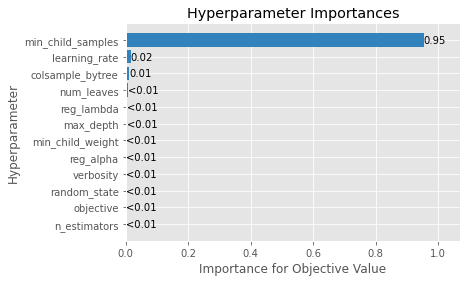

In [77]:
plot_param_importances(study)

In [78]:
cat_optuna = CatBoostRegressor(**study_cat.best_params,
                               early_stopping_rounds=50)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False)

y_pred = cat_optuna.predict(X_test)

# Получаем параметры
get_metrics(y_test, y_pred, X_test, 'CatBoostRegressor_optuna1')
show_scores(cat_optuna,
            X_train,
            y_train,
            X_test,
            y_test,
            metric_fun=mean_absolute_error)

Check overfitting:
mean_absolute_error train: 36208.730
mean_absolute_error test: 38843.210
delta = 7.3 %


metrics_mae    metrics_mse  metrics_rmse  \
method                                                                     
LinearRegression_baseline         44569.178 3078826533.693     55487.174   
RandomForestRegressor_baseline    39026.034 2435485985.137     49350.643   
LGBMRegressor_baseline            39083.738 2548423106.408     50481.909   
CatBoostRegressor_baseline        38770.008 2493063223.049     49930.584   
LGMBRegressor_optuna              38865.114 2528815620.978     50287.331   
CatBoostRegressor_optuna1         38843.210 2483097554.482     49830.689   

                                metrics_rmsle  metrics_rsq  metrics_rsq_adj  \
method                                                                        
LinearRegression_baseline               0.503        0.168            0.163   
RandomForestRegressor_baseline          0.401        0.342            0.338   
LGBMRegressor_baseline                  0.407        0.311            0.307   
CatBoostRegressor_baseline              0.400        0.326            0.322   
LGMBRegressor_optuna                    0.400        0.316            0.313   
CatBoostRegressor_optuna1               0.402        0.329            0.325   

                                metrics_mpe  metrics_mape  metrics_wape  
method                                                                   
LinearRegression_baseline           -23.733        47.557        31.401  
RandomForestRegressor_baseline      -15.225        36.074        27.495  
LGBMRegressor_baseline              -10.647        35.159        27.536  
CatBoostRegressor_baseline           -9.268        34.290        27.315  
LGMBRegressor_optuna                 -8.507        33.589        27.382  
CatBoostRegressor_optuna1           -10.638        34.883        27.366

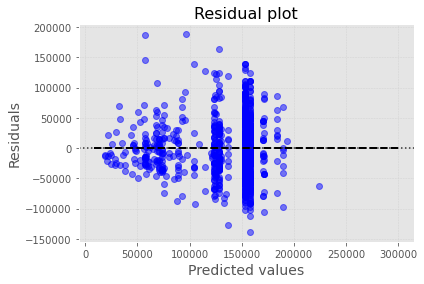

In [79]:
# Plot the residuals vs predicted values
residuals = y_test - y_pred
sns.residplot(x=y_pred, y=residuals, color='blue', scatter_kws={'alpha':0.5})
plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=2)
plt.xlabel('Predicted values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.title('Residual plot', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.show()

### Feature importance (best model)

In [80]:
from sklearn.inspection import permutation_importance

#### CatBoostRegressor_baseline

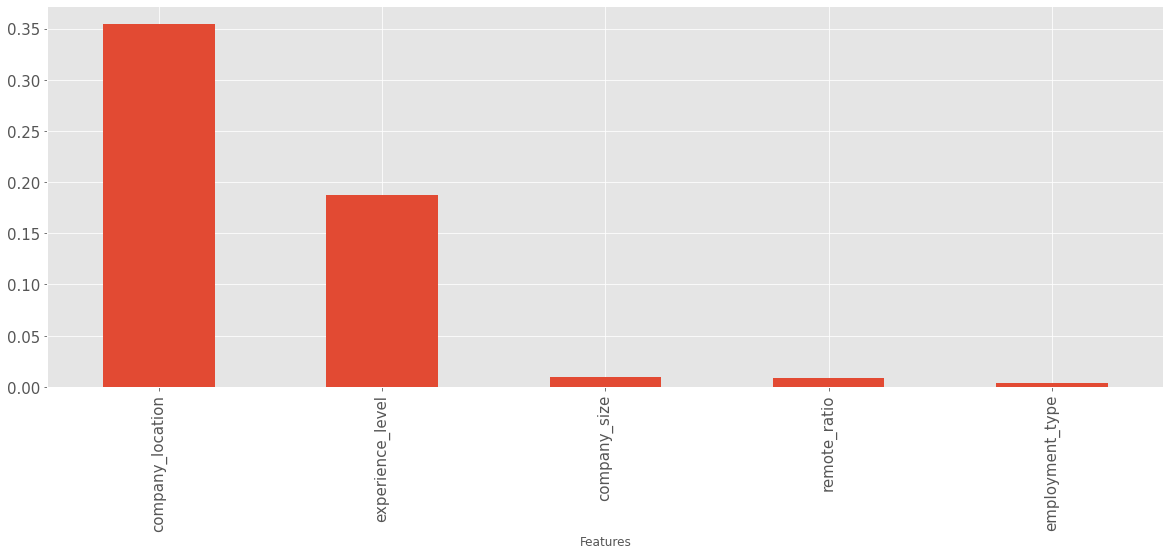

In [81]:
r = permutation_importance(cb, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### RandomForestRegressor_baseline

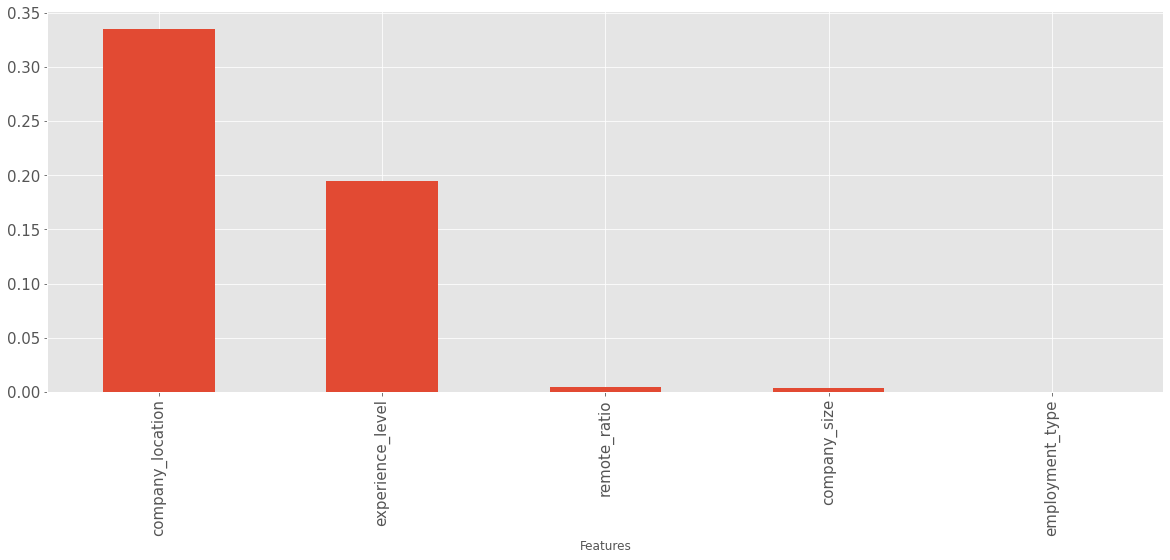

In [82]:
r = permutation_importance(lgb_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Categorical target

### Import

In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report
from catboost import CatBoostClassifier

In [93]:
X = features
y = target_cat

### train / test split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RANDOM_STATE)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RANDOM_STATE)

eval_set = [(X_val, y_val)]

### Modeling

#### General functions

In [95]:
score_results = []

In [99]:
def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Generate a table of metrics for classification tasks"""
    metrics_accuracy = accuracy_score(y_test, y_pred)
    metrics_precision = precision_score(y_test, y_pred, average='weighted')
    metrics_recall = recall_score(y_test, y_pred, average='weighted')
    metrics_f1 = f1_score(y_test, y_pred, average='weighted')
    metrics_roc_auc_score = roc_auc_score(y_test, y_pred, average='weighted')

    score_results.append({
        'method': name,
        'metrics_accuracy': metrics_accuracy,
        'metrics_precision': metrics_precision,
        'metrics_recall': metrics_recall,
        'metrics_f1': metrics_f1,
        'metrics_roc_auc_score': metrics_roc_auc_score
    })


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """Check for overfitting
    metric_fun = accuracy_score, precision_score, recall_score, f1_score..."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    metric_train = metric_fun(y_train, y_pred_train)
    metric_test = metric_fun(y_test, y_pred_test)

    print('Check overfitting:')
    print(f'{metric_fun.__name__} train: %.3f' % metric_train)
    print(f'{metric_fun.__name__} test: %.3f' % metric_test)
    print(
        f'delta = {(abs(metric_train - metric_test) / metric_train * 100):.1f} %'
    )


def show_scores(model, X_train, y_train, X_test, y_test, metric_fun):
    resultScoreData = pd.DataFrame(score_results).set_index('method')
    resultScoreData = resultScoreData[[
        'metrics_accuracy', 'metrics_precision', 'metrics_recall',
        'metrics_f1', 'metrics_roc_auc_score'
    ]]
    resultScoreData = resultScoreData.drop_duplicates()
    check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun)
    return resultScoreData


def classification_report_and_roc(model, y_test, y_pred):
    """Generate classification report and plot ROC curve"""
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.title('ROC curve')
    plt.xlabel('FPR (Precision)')
    plt.ylabel('TPR (Recall)')

    plt.plot(fpr, tpr)
    plt.plot((0, 1), ls='dashed', color='black')
    plt.show()

    print('Area under curve (AUC):', auc(fpr, tpr))

### Baseline

#### CatBoostClassifier

In [108]:
cat_features = X_val.select_dtypes('category').columns.tolist()

cb_clf = CatBoostClassifier(random_seed=RANDOM_STATE,
                        eval_metric='Accuracy',
                        cat_features=cat_features,
                        allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb_clf.fit(X_train,
       y_train,
       eval_set=eval_set,
       verbose=100,
       early_stopping_rounds=100)

y_pred_cb_clf = cb_clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# classification_report_and_roc(cb_clf, y_test, y_pred_cb_clf)

Learning rate set to 0.110205
0:	learn: 0.2728582	test: 0.2696629	best: 0.2696629 (0)	total: 99.2ms	remaining: 1m 39s
100:	learn: 0.3653708	test: 0.2853933	best: 0.2988764 (76)	total: 9.82s	remaining: 1m 27s
200:	learn: 0.4258459	test: 0.2696629	best: 0.3078652 (165)	total: 20.3s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3078651685
bestIteration = 165

Shrink model to first 166 iterations.
Classification Report:


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

### Feature importance (best model)

In [80]:
from sklearn.inspection import permutation_importance

#### CatBoostClassifier

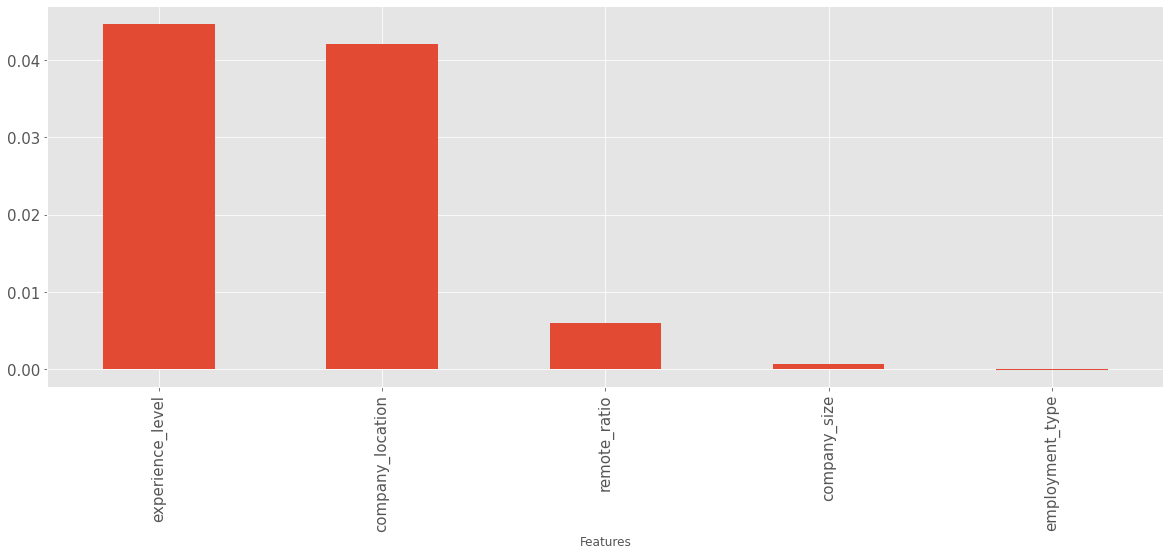

In [104]:
r = permutation_importance(cb_clf, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()